# MACD and Donchain Scores Indicator Scoring System
## MACD Score (-100 to +100)

The MACD score combines three components:

### MACD Line Position vs. Signal Line (40%)

- Positive when MACD line is above signal line (bullish)
- Negative when MACD line is below signal line (bearish)


### MACD Line Position vs. Zero (30%)

- Positive when MACD line is above zero (strong bullish trend)
- Negative when MACD line is below zero (strong bearish trend)


### Histogram Momentum (30%)

Measures the rate of change in the histogram

- Positive when histogram is increasing (accelerating momentum)
- Negative when histogram is decreasing (decelerating momentum)



## Donchian Channel Score (-100 to +100)
The Donchian score combines three components:

### Price Position Within Channel (50%)

- +50 when price is at the upper band
- 0 when price is at the middle band
- -50 when price is at the lower band


### Channel Direction (30%)

- Positive when channel is trending upward
- Negative when channel is trending downward


### Channel Width Trend (20%)

- Positive when channel is widening (increasing volatility)
- Negative when channel is narrowing (decreasing volatility)



## Combined Score
The combined score is a simple average of the MACD and Donchian scores, giving equal weight to momentum (MACD) and price range (Donchian) indicators.

### How to Interpret the Scores

### Individual Score Interpretation
#### MACD Score:

- Above +50: Strong bullish momentum
- +25 to +50: Moderate bullish momentum
- -25 to +25: Neutral momentum
- -50 to -25: Moderate bearish momentum
- Below -50: Strong bearish momentum

#### Donchian Score:

- Above +50: Price trending strongly upward, near upper band
- +25 to +50: Price trending upward, above middle band
- -25 to +25: Price within middle range of channel
- -50 to -25: Price trending downward, below middle band
- Below -50: Price trending strongly downward, near lower band

#### Combined Score Trading Signals
The combined score translates directly into trading signals:

- +75 to +100: Strong Buy
- +50 to +75: Buy
- +25 to +50: Weak Buy
- -25 to +25: Neutral (Hold)
- -50 to -25: Weak Sell
- -75 to -50: Sell
- -100 to -75: Strong Sell

## Benefits of the Scoring System

- Simplification: Converts complex indicator patterns into intuitive numerical values
- Normalization: All scores use the same -100 to +100 scale
- Combination: Easily combines different indicators into a single actionable signal
- Visualization: Shows indicator strength and transitions between states
- Customization: Weights of components can be adjusted based on trading strategy

## Visual Interpretation
The script creates a four-panel visualization:

- Top panel: Price chart with Donchian Channels
- Second panel: MACD indicator with histogram
- Third panel: Indicator scores (MACD, Donchian, and Combined)
- Bottom panel: Trading signal visualization with color-coded bars

The color coding in the trading signal panel makes interpretation intuitive:

- Dark Green: Strong Buy
- Green: Buy
- Light Green: Weak Buy
- Gray: Neutral
- Pink: Weak Sell
- Red: Sell
- Dark Red: Strong Sell

### Practical Usage

Trend Confirmation: When both MACD and Donchian scores agree (both positive or both negative), it confirms a strong trend.
Divergence Detection: When scores move in opposite directions, it may indicate a potential trend reversal.
Entry and Exit Points:

- Enter long positions when combined score crosses above +50
- Enter short positions when combined score crosses below -50
- Exit positions when combined score crosses zero in the opposite direction


### Risk Management:

- Adjust position sizing based on score strength
- Tighten stop-losses when scores show early signs of reversal
- Take partial profits when scores begin to moderate from extremes

In [1]:
from typing import List, Dict, Any, Optional
from langgraph.graph import StateGraph, END

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
import pandas as pd
import numpy as np
import yfinance as yf  
import os
from langgraph.prebuilt import ToolNode 
from langchain.agents.agent_types import AgentType
import os
from google.oauth2 import service_account
from dotenv import dotenv_values
import json
# import vertexai
# from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings, GoogleGenerativeAI
# from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

In [2]:
from langgraph.graph import StateGraph, START, END

In [2]:
config = dotenv_values("./keys/.env")

OPENAI_API_KEY = config.get("OPENAI_API_KEY")
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [3]:
# Ensure you have your OpenAI API key set as an environment variable
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("Please set the OPENAI_API_KEY environment variable.")

In [4]:
# Set parameters
ticker = "TLSA"
period = '1y'  # 1 year of data
window = 20    # 20-day Donchian Channel

# MACD parameters
fast_period = 12
slow_period = 26
signal_period = 9

# Download data
print(f"Downloading data for {ticker}...")

data = yf.download(ticker, period=period,multi_level_index=False) 

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
#help(yf.download)


In [43]:
@tool
def calculate_macd_score(symbol, period="1y", fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate a MACD score between -100 and 100 for the tickek and given period
    first we create the MACD indicator with the parameters fast_period (int): Fast EMA period, slow_period (int): Slow EMA period and signal_period (int): Signal line period
    The MACD score combines three components:

    ### MACD Line Position vs. Signal Line (40%)
    
    - Positive when MACD line is above signal line (bullish)
    - Negative when MACD line is below signal line (bearish)
    
    
    ### MACD Line Position vs. Zero (30%)
    
    - Positive when MACD line is above zero (strong bullish trend)
    - Negative when MACD line is below zero (strong bearish trend)
    
    
    ### Histogram Momentum (30%)
    
    Measures the rate of change in the histogram
    
    - Positive when histogram is increasing (accelerating momentum)
    - Negative when histogram is decreasing (decelerating momentum)
    
    Parameters:
    symbol (str): ticker Yahoo finance 
    period (str): Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max. Either Use period parameter or use start and end
    fast_period (int) : This parameter defines the period (number of days/periods) for the "fast" Exponential Moving Average (EMA). By default, it's set to 12 periods, which is the standard setting for MACD. This shorter period EMA is more responsive to recent price changes.
    slow_period (int) : This parameter defines the period for the "slow" EMA. By default, it's set to 26 periods, which is also standard. This longer period EMA responds more slowly to price changes and captures longer-term trends.
    signal_period( int) : This parameter defines the period for calculating the signal line, which is an EMA of the MACD line itself. By default, it's set to 9 periods, which is the typical setting. The signal line helps identify potential buy/sell signals when it crosses the MACD line.

    Returns:
    (str) : message with:
    Symbol: {symbol}, Period: {period}
    Latest MACD score: {current_macd_score:.2f}
    Latest component 1. MACD line position relative to signal line (40% of score): {current_line_position:.2f}
    Latest component 3: MACD line position relative to zero (30% of score) {current_zero_position:.2f}
    Latest component 3 Histogram direction and momentum (30% of score) : {current_hist_momentum:.2f}
    """
    

    data = yf.download(symbol, period=period,multi_level_index=False) 
    # Calculate the fast and slow EMAs
    ema_fast = data['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = data['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # Calculate the MACD line
    macd_line = ema_fast - ema_slow
    
    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line
    
    # Create result DataFrame
    macd_data = pd.DataFrame({
        'macd_line': macd_line,
        'signal_line': signal_line,
        'macd_histogram': macd_histogram
    }, index=data.index)
    
    score = pd.Series(0, index=data.index)
    
    # Component 1: MACD line position relative to signal line (40% of score)
    # Normalize using typical range
    typical_range = macd_data['macd_line'].std() * 3  # 3 standard deviations
    
    if typical_range == 0:
        typical_range = 0.001  # Prevent division by zero
        
    line_position = (macd_data['macd_line'] - macd_data['signal_line']) / typical_range
    component1 = line_position.clip(-1, 1) * 40
    
    # Component 2: MACD line position relative to zero (30% of score)
    zero_position = macd_data['macd_line'] / typical_range
    component2 = zero_position.clip(-1, 1) * 30
    
    # Component 3: Histogram direction and momentum (30% of score)
    # Rate of change in histogram (smoothed)
    hist_change = macd_data['macd_histogram'].diff(3).rolling(window=3).mean()
    hist_typical_range = hist_change.std() * 3
    
    if hist_typical_range == 0:
        hist_typical_range = 0.001  # Prevent division by zero
        
    hist_momentum = hist_change / hist_typical_range
    component3 = hist_momentum.clip(-1, 1) * 30
    
    # Combine components
    score = component1 + component2 + component3
    current_macd_score = float(score.iloc[-1])
    current_line_position = float(component1.iloc[-1])
    current_zero_position = float(component2.iloc[-1])
    current_hist_momentum = float(component3.iloc[-1])
    message = f"""
    Symbol: {symbol}, Period: {period}\n
    Latest MACD score: {current_macd_score:.2f}\n
    Latest first component score. MACD line position relative to signal line (40% of score): {current_line_position:.2f}\n
    Latest second component score. MACD line position relative to zero (30% of score): {current_zero_position:.2f}\n
    Latest third component score. Histogram direction and momentum (30% of score) : {current_hist_momentum:.2f}
    """
    return message

In [44]:
print(calculate_macd_score.invoke("UBS"))

[*********************100%***********************]  1 of 1 completed


    Symbol: UBS, Period: 1y

    Latest MACD score: -65.27

    Latest first component score. MACD line position relative to signal line (40% of score): -17.60

    Latest second component score. MACD line position relative to zero (30% of score): -27.32

    Latest third component score. Histogram direction and momentum (30% of score) : -20.35
    


In [8]:
@tool
def calculate_donchian_channel_score(symbol, period="1y", window=20):
    """
    Calculate Donchian score for the given symbol, period and window period
    Donchian Channel Score (-100 to +100)

    Parameters:
    symbol (str): ticker Yahoo finance 
    period (str): Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max. Either Use period parameter or use start and end
    window (int): The lookback period for calculating channels upper, middle, and lower bands
    ### Price Position Within Channel (50%)

    - +50 when price is at the upper band
    - 0 when price is at the middle band
    - -50 when price is at the lower band
    
    Donchian Channel Score (-100 to +100). it has 3 components
    
    ### Channel Direction (30%)
    
    - Positive when channel is trending upward
    - Negative when channel is trending downward
    
    
    ### Channel Width Trend (20%)
    
    - Positive when channel is widening (increasing volatility)
    - Negative when channel is narrowing (decreasing volatility)
    Returns:
    (str) : message with:
    Symbol: {symbol}, Period: {period}\n
    Latest donchian band score: {current_donchian_score:.2f}\n
    Latest first component score. Position within the channel (50% of score) 0% at lower band, 50% at middle band, 100% at upper band: {current_line_position:.2f}\n
    Latest second component score. Channel direction (30% of score): {current_zero_position:.2f}\n
    Latest third component score. Channel width trend (20% of score) Narrowing channel is bearish, widening is bullish: {current_hist_momentum:.2f}

    """
    data = yf.download(symbol, period=period,multi_level_index=False) 
    # Calculate upper and lower bands
    upper_band = data['High'].rolling(window=window).max()
    lower_band = data['Low'].rolling(window=window).min()
    
    # Calculate middle band (average of upper and lower)
    middle_band = (upper_band + lower_band) / 2
    
    # Create result DataFrame
    channels = pd.DataFrame({
        'upper': upper_band,
        'middle': middle_band,
        'lower': lower_band
    }, index=data.index)
    

    score = pd.Series(0, index=data.index)
    
    # Component 1: Position within the channel (50% of score)
    # 0% at lower band, 50% at middle band, 100% at upper band
    channel_width = channels['upper'] - channels['lower']
    
    # Prevent division by zero
    channel_width = channel_width.replace(0, 0.001)
    
    position_pct = (data['Close'] - channels['lower']) / channel_width
    component1 = ((position_pct * 2) - 1) * 50  # Scale to -50 to +50
    
    # Component 2: Channel direction (30% of score)
    channel_direction = channels['middle'].diff(5).rolling(window=5).mean()
    channel_direction_range = channel_direction.std() * 3
    
    if channel_direction_range == 0:
        channel_direction_range = 0.001  # Prevent division by zero
        
    normalized_direction = channel_direction / channel_direction_range
    component2 = normalized_direction.clip(-1, 1) * 30
    
    # Component 3: Channel width trend (20% of score)
    # Narrowing channel is bearish, widening is bullish
    width_change = channel_width.diff(5).rolling(window=5).mean()
    width_change_range = width_change.std() * 3
    
    if width_change_range == 0:
        width_change_range = 0.001  # Prevent division by zero
        
    normalized_width = width_change / width_change_range
    component3 = normalized_width.clip(-1, 1) * 20
    
    # Combine components
    score = component1 + component2 + component3
    
    current_donchian_score = float(score.iloc[-1])
    current_line_position = float(component1.iloc[-1])
    current_zero_position = float(component2.iloc[-1])
    current_hist_momentum = float(component3.iloc[-1])
    message = f"""
    Symbol: {symbol}, Period: {period}\n
    Latest donchian band score: {current_donchian_score:.2f}\n
    Latest first component score. Position within the channel (50% of score) 0% at lower band, 50% at middle band, 100% at upper band: {current_line_position:.2f}\n
    Latest second component score. Channel direction (30% of score): {current_zero_position:.2f}\n
    Latest third component score. Channel width trend (20% of score) Narrowing channel is bearish, widening is bullish: {current_hist_momentum:.2f}
    """
    return message


In [45]:
print(calculate_donchian_channel_score.invoke("TLSA"))

[*********************100%***********************]  1 of 1 completed


    Symbol: TLSA, Period: 1y

    Latest donchian band score: -44.44

    Latest first component score. Position within the channel (50% of score) 0% at lower band, 50% at middle band, 100% at upper band: -43.75

    Latest second component score. Channel direction (30% of score): 2.63

    Latest third component score. Channel width trend (20% of score) Narrowing channel is bearish, widening is bullish: -3.32
    


In [27]:
@tool
def calculate_combined_score(macd_score, donchian_score):
    """
    Calculate a combined indicator score between -100 and 100.
    
    Parameters:
    macd_score (float): Latest MACD score
    donchian_score (float):  Latest donchian band score
    
    Returns:
    float: Combined score between -100 and 100
    """
    # Equal weight to both indicators
    return (float(macd_score) + float(donchian_score)) / 2

In [28]:
calculate_combined_score.invoke(input={"macd_score":"-13.74", "donchian_score":"-28.12"})

-20.93

In [29]:
# Interpret scores
@tool
def interpret_combined_score(score):
    """
    Given a score return its interpretation in string format
    Args:
    score (float) value between -100 and 100
    return (string) string interpretion of the score. a Literal of this list "Strong Buy Signal","Buy Signal", "Weak Buy Signal", "Neutral",  "Weak Sell Signal",  "Sell Signal", "Strong Sell Signal"
    """
    score = float(score)
    if score > 75:
        return "Strong Buy Signal"
    elif score > 50:
        return "Buy Signal"
    elif score > 25:
        return "Weak Buy Signal"
    elif score > -25:
        return "Neutral"
    elif score > -50:
        return "Weak Sell Signal"
    elif score > -75:
        return "Sell Signal"
    else:
        return "Strong Sell Signal"

In [48]:
interpret_combined_score.invoke("-95")

'Strong Sell Signal'

In [49]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o-mini")

In [50]:
tools = [calculate_macd_score,calculate_donchian_channel_score,calculate_combined_score, interpret_combined_score]

llm_with_tools = llm.bind_tools(tools)

In [52]:

# import operator
# from typing import Annotated, Sequence, TypedDict

# from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_core.messages import ToolMessage

# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]

In [53]:

from typing import Annotated

from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.messages import ToolMessage

from langgraph.graph import StateGraph, START, MessagesState, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    """Always use tools to fulfill user requests.
    You are a clever chatbot which recomemd what to do with the stock user request based in the interpretation of the macd z-score and Donwchain bands Score and a the combined
    macd donwchain

    MACD and Donchain Scores Indicator Scoring System
    MACD Score (-100 to +100)
    The MACD score combines three components:
    
    MACD Line Position vs. Signal Line (40%)
    Positive when MACD line is above signal line (bullish)
    Negative when MACD line is below signal line (bearish)
    MACD Line Position vs. Zero (30%)
    Positive when MACD line is above zero (strong bullish trend)
    Negative when MACD line is below zero (strong bearish trend)
    Histogram Momentum (30%)
    Measures the rate of change in the histogram
    
    Positive when histogram is increasing (accelerating momentum)
    Negative when histogram is decreasing (decelerating momentum)
    Donchian Channel Score (-100 to +100)
    The Donchian score combines three components:
    
    Price Position Within Channel (50%)
    +50 when price is at the upper band
    0 when price is at the middle band
    -50 when price is at the lower band
    Channel Direction (30%)
    Positive when channel is trending upward
    Negative when channel is trending downward
    Channel Width Trend (20%)
    Positive when channel is widening (increasing volatility)
    Negative when channel is narrowing (decreasing volatility)
    Combined Score
    The combined score is a simple average of the MACD and Donchian scores, giving equal weight to momentum (MACD) and price range (Donchian) indicators.
    
    How to Interpret the Scores
    
    Individual Score Interpretation
    
    MACD Score:
    Above +50: Strong bullish momentum
    +25 to +50: Moderate bullish momentum
    -25 to +25: Neutral momentum
    -50 to -25: Moderate bearish momentum
    Below -50: Strong bearish momentum
    
    Donchian Score:
    Above +50: Price trending strongly upward, near upper band
    +25 to +50: Price trending upward, above middle band
    -25 to +25: Price within middle range of channel
    -50 to -25: Price trending downward, below middle band
    Below -50: Price trending strongly downward, near lower band
    
    Combined Score Trading Signals
    The combined score translates directly into trading signals:
    
    +75 to +100: Strong Buy
    +50 to +75: Buy
    +25 to +50: Weak Buy
    -25 to +25: Neutral (Hold)
    -50 to -25: Weak Sell
    -75 to -50: Sell
    -100 to -75: Strong Sell
    
    1. If you do not have enough inputs to execute a tool then you can ask for more information.
    2. calculate the Score and return am answer based in what the tools return you and following the guidelines to  Interpretate it I give you 
    3. First Calculate macd score and interpretate its value according to the instructions
    4. Second Calculate Donchian bands score and interpretate its value according to the instructions
    5. third Calculate combined score and interpretate using the tool
    """
    # Filter out messages with image type
    # text_messages = [msg for msg in state["messages"] if msg['content'][0].get("type") != "image"]
    text_messages = [
        msg for msg in state["messages"]
        if not (isinstance(msg.content, list) and msg.content[0].get("type") == "image_url")
    ]

    # Invoke LLM with only text messages
    return {"messages": [llm_with_tools.invoke(text_messages)]}




In [54]:

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)

graph = graph_builder.compile()

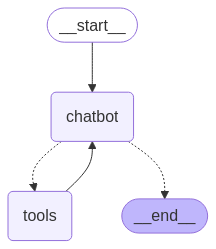

In [55]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
from langchain_core.messages import HumanMessage
import pprint
config = {"configurable": {"thread_id": "20"}}
message = graph.invoke(
        {
            "messages": [
                (
                    "user",
                    """Recomend if buy or sell UBS based in Calculations of the Macd score, donchian bands score and combined score.
                    
                    data period = '1y'  # 1 year of data
                    window = 20    # 20-day Donchian Channel
                    
                    # MACD parameters
                    fast_period = 12
                    slow_period = 26
                    signal_period = 9""",
                )
            ]
        },
        config,
    )

     


[*********************100%***********************]  1 of 1 completed



In [57]:
message

{'messages': [HumanMessage(content="Recomend if buy or sell UBS based in Calculations of the Macd score, donchian bands score and combined score.\n\n                    data period = '1y'  # 1 year of data\n                    window = 20    # 20-day Donchian Channel\n\n                    # MACD parameters\n                    fast_period = 12\n                    slow_period = 26\n                    signal_period = 9", additional_kwargs={}, response_metadata={}, id='077a340c-55ff-4759-a8b7-af6953aa38bc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7FijPcwJCyk2RBEQCR9T6PQT', 'function': {'arguments': '{"symbol": "UBS", "period": "1y", "fast_period": 12, "slow_period": 26, "signal_period": 9}', 'name': 'calculate_macd_score'}, 'type': 'function'}, {'id': 'call_ITgKlYnBjEKvzahBioJWZfVf', 'function': {'arguments': '{"symbol": "UBS", "period": "1y", "window": 20}', 'name': 'calculate_donchian_channel_score'}, 'type': 'function'}], 'refusal': None}, response_me

In [58]:
print(message["messages"][-1].content)

Based on the calculations:

- **MACD Score**: -65.27
- **Donchian Band Score**: -57.41
- **Combined Score**: -61.34

### Recommendation:
The interpretation of the combined score is a **"Sell Signal."**


In [59]:
from langchain_core.messages import HumanMessage
import pprint
config = {"configurable": {"thread_id": "20"}}
message = graph.invoke(
        {
            "messages": [
                (
                    "user",
                    """Recomend if buy or sell TLSA based in Calculations of the Macd score, donchian bands score and combined score.
                    
                    data period = '6mo'  # 6 months
                    window = 30    # 30-day Donchian Channel
                    
                    # MACD parameters
                    fast_period = 12
                    slow_period = 26
                    signal_period = 9""",
                )
            ]
        },
        config,
    )


[*********************100%***********************]  1 of 1 completed



In [60]:
message

{'messages': [HumanMessage(content="Recomend if buy or sell TLSA based in Calculations of the Macd score, donchian bands score and combined score.\n\n                    data period = '6mo'  # 6 months\n                    window = 30    # 30-day Donchian Channel\n\n                    # MACD parameters\n                    fast_period = 12\n                    slow_period = 26\n                    signal_period = 9", additional_kwargs={}, response_metadata={}, id='8b960f6c-2571-477e-a1c1-ecab4f979c97'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WRuMcBbIKBJs5cYmIvEC1NTf', 'function': {'arguments': '{"symbol": "TLSA", "period": "6mo", "fast_period": 12, "slow_period": 26, "signal_period": 9}', 'name': 'calculate_macd_score'}, 'type': 'function'}, {'id': 'call_4ArHbqrYEReCKpNVNqNosqWk', 'function': {'arguments': '{"symbol": "TLSA", "period": "6mo", "window": 30}', 'name': 'calculate_donchian_channel_score'}, 'type': 'function'}], 'refusal': None}, response_me

In [61]:
print(message["messages"][-1].content)

Based on the analysis of TLSA using the MACD score, Donchian Bands score, and the combined score, here's the summary:

- **MACD Score: -11.51**
  - MACD line position relative to the signal line: -10.96 (bearish)
  - MACD line position relative to zero: -5.16 (bearish)
  - Histogram momentum: 4.61 (some positive momentum)

- **Donchian Bands Score: -35.79**
  - Position within the channel: -37.39 (near the lower band)
  - Channel direction: 6.37 (slight upward)
  - Channel width trend: -4.77 (narrowing channel)

- **Combined Score: -23.65**
  - Interpretation: Neutral

### Recommendation:
The overall recommendation for TLSA is **Neutral**. This suggests that there is no strong reason to buy or sell at this time. It's advisable to monitor market conditions and look for more favorable indicators before making a decision.
